# Getting the right T

Goal : find T such as [A1,...,A1,A2,...,A2] is the optimal split.
                                T
                                
Definition: risque: $R(A)=\frac{1}{n}\sum_{i}^{n}\sum_{t}^{T} || Y_{i,t}-A_{t}X_{i,t}||²$

Trois modèles:
- Général : A = (A,A,...,A)
- Spécifique : A = (A1,A1,...,A5,A5)
- Selectif: A = (A1,...,A1,A2,...,A2) avec split en T^

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "4" 
os.environ["NUMEXPR_NUM_THREADS"] = "4" 
os.environ["OMP_NUM_THREADS"] = "4" 

import numpy as np
import pandas as pd
import pprint
import matplotlib
import matplotlib.pyplot as plt        
import sys
import multiprocessing as mp
import time

sys.path.append('../scripts/')
from models import BaseModels, DataCleaner, ModelPlots, DataModel

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")
speeds = pd.read_pickle("../data/monthsSpeed__0.pckl")
counts = pd.read_pickle('../data/monthsCount__0.pckl')
data_cleaner = DataCleaner(speeds, segmentsMeta, mergeResults, counts)
speedDF = data_cleaner.data

nSegments = len(speedDF)

## Fonction de rique

In [30]:
def risque(A, X, Y):
    n = 45
    T = 19
    r = 0
    
    for i in range(n):
        for t in range(T):
            r += np.mean((Y[i*t] - np.dot(A[t], X[i*t]))**2)
    r = r/(n*T)
    
    return r
    

## Etude des risques en fonction de T

### Modèle Général

In [3]:
Z = []

for i in range(int((speedDF.shape[1])/20)):
    Z.append(speedDF.iloc[:,i*20:(i+1)*20].values)

print("Z Created!")
n = len(Z)
print("n =", n)

Z = np.array(Z)

Z_train = Z[:45]
Z_test = Z[45:]

M = (1/45)*Z_train.sum(axis=0)

for i in range(45):
    Z_train[i] = Z_train[i] - M
for i in range(65-45):
    Z_test[i] = Z_test[i] - M
    
print("Z Centré !")


def X_Y(Z):
    new_X = Z[:,:,:-1]
    new_Y = Z[:,:,1:]
    new_X = np.concatenate(new_X, axis=1)
    new_Y = np.concatenate(new_Y, axis=1)
    return new_X.T, new_Y.T

new_X_train, new_Y_train  = X_Y(Z_train)
print(new_X_train.shape, new_Y_train.shape)
new_X_test, new_Y_test = X_Y(Z_test)
print(new_X_test.shape, new_Y_test.shape)

Z Created!
n = 65
Z Centré !
(855, 556) (855, 556)
(380, 556) (380, 556)


In [4]:
A_lasso_parra = [linear_model.LassoCV(n_jobs=4, cv=5, max_iter=10000, tol=0.0001, n_alphas=100) for i in range(nSegments)]

In [5]:
def fit_lasso(i):
    A_lasso_parra[i].fit(new_X_train, new_Y_train[:, i])
    print(i,"alpha:",A_lasso_parra[i].alpha_,"\nalphas", len(A_lasso_parra[i].alphas_), "\nnb iter:", A_lasso_parra[i].n_iter_)
    return A_lasso_parra[i]

In [6]:
%%time

pool = mp.Pool(processes=12)

results = pool.map(fit_lasso, range(nSegments))

60 alpha: 5.492640533537323 
alphas 100 
nb iter: 70
120 alpha: 7.342444934958369 
alphas 100 
nb iter: 65
36 alpha: 15.15035268851419 
alphas 100 
nb iter: 64
108 alpha: 7.7090578412284625 
alphas 100 
nb iter: 34
72 alpha: 2.737651881657627 
alphas 100 
nb iter: 44
24 alpha: 8.521574229500153 
alphas 100 
nb iter: 57
84 alpha: 8.545676359583654 
alphas 100 
nb iter: 18
132 alpha: 8.458312464588507 
alphas 100 
nb iter: 22
37 alpha: 2.746168687491727 
alphas 100 
nb iter: 56
61 alpha: 2.8656663789331382 
alphas 100 
nb iter: 37
73 alpha: 2.0497975934421153 
alphas 100 
nb iter: 54
12 alpha: 7.466387050317008 
alphas 100 
nb iter: 21
96 alpha: 6.771781306939158 
alphas 100 
nb iter: 23
48 alpha: 4.124023339233715 
alphas 100 
nb iter: 19
121 alpha: 12.11469567236471 
alphas 100 
nb iter: 15
0 alpha: 19.442736717517935 
alphas 100 
nb iter: 1
49 alpha: 8.851589363177052 
alphas 100 
nb iter: 49
38 alpha: 7.13887308085358 
alphas 100 
nb iter: 41
62 alpha: 11.77095707815801 
alphas 100 


In [7]:
pool.close()

In [10]:
mse=0
for i in range(len(results)):
    mse += np.mean(results[i].mse_path_[np.where(results[i].alphas_ == results[i].alpha_)[0][0]])
mse = mse/len(results)
print("MSE:",mse)

MSE: 99.58364336189145


In [9]:
preds_lasso_para = []

for i in range(nSegments):
    preds_lasso_para.append(results[i].predict(new_X_test))

preds_lasso_para = np.array(preds_lasso_para)

In [12]:
print("Avec CV")
print("MSE:", mean_squared_error(preds_lasso_para.T.flatten(), new_Y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso_para.T.flatten(), new_Y_test.flatten()))

Avec CV
MSE: 102.27059546136078
MAE: 6.935341225207588


#### Evaluation du risque

In [49]:
A = [a.coef_ for a in results]
A = [A]*19
A = np.array(A)

In [50]:
risque(A, new_X_train, new_Y_train)

89.59049561290934

**Risque du modèle général: 89.59**

### Modèle Spécifique

In [114]:
Z2 = []

for i in range(int((speedDF.shape[1])/20)):
    Z2.append(speedDF.iloc[:,i*20:(i+1)*20].values)

print("Z Created!")
n = len(Z2)
print("n =", n)

Z2 = np.array(Z2)

Z2_train = Z[:45]
Z2_test = Z[45:]


print("Z2_train shape:", Z2_train.shape)
Z2_train = np.append(Z2_train, np.zeros((45,556,1)), axis=2)
print("Z2_train shape:", Z2_train.shape)

Z2_test = np.append(Z2_test, np.zeros((20,556,1)), axis=2)


Zt_train = []
for i in range(5):
    Zt_train.append(Z2_train[:,:,i*4:(i+1)*4+1])
Zt_train = np.array(Zt_train)
print("Zt_train shape:", Zt_train.shape)


Zt_test = []
for i in range(5):
    Zt_test.append(Z2_test[:,:,i*4:(i+1)*4+1])
Zt_test = np.array(Zt_test)
print("Zt_test shape:", Zt_test.shape)


for j in range(5):
    M = (1/45)*Zt_train[j].sum(axis=0)

    for i in range(45):
        Zt_train[j][i] = Zt_train[j][i] - M
    for i in range(65-45):
        Zt_test[j][i] = Zt_test[j][i] - M
    
print("Z Centré !")
print(Zt_train[1,:,1,3].mean())

X_train_time = [X_Y(Zt_train[i])[0] for i in range(4)]
X_train_time.append(X_Y(Zt_train[-1][:,:,:-1])[0])
Y_train_time = [X_Y(Zt_train[i])[1] for i in range(4)]
Y_train_time.append(X_Y(Zt_train[-1][:,:,:-1])[1])

X_test_time = [X_Y(Zt_test[i])[0] for i in range(4)]
X_test_time.append(X_Y(Zt_test[-1][:,:,:-1])[0])
Y_test_time = [X_Y(Zt_test[i])[1] for i in range(4)]
Y_test_time.append(X_Y(Zt_test[-1][:,:,:-1])[1])
#X_train_time, Y_train_time  = np.array([X_Y(Zt_train[i]) for i in range(5)])[:,0], np.array([X_Y(Zt_train[i]) for i in range(5)])[:,1]
#print(X_train_time.shape, Y_train_time.shape)
#X_test_time, Y_test_time = np.array([X_Y(Zt_test[i]) for i in range(5)])[:,0], np.array([X_Y(Zt_test[i]) for i in range(5)])[:,1]
#print(X_test_time.shape, Y_test_time.shape)


Z Created!
n = 65
Z2_train shape: (45, 556, 20)
Z2_train shape: (45, 556, 21)
Zt_train shape: (5, 45, 556, 5)
Zt_test shape: (5, 20, 556, 5)
Z Centré !
9.671276125623585e-16


**Attention X_train_time et cie listes de taille 5 avec les 4 premiers de shape 180,556 et le dernier de shape 135, 556**

**Pour test_time c'est 80,556 et 60,556**

In [115]:
A_lasso_time = [linear_model.LassoCV(n_jobs=-1, cv=5, max_iter=10000, tol=0.0001, n_alphas=100) for i in range(nSegments*5)]

In [118]:
def fit_lasso_time(i):
    j = i % 556
    k = i // 556
    A_lasso_time[i].fit(X_train_time[k], Y_train_time[k][:, j])
    print("timeframe:", k, "section:", j, "alpha:", A_lasso_time[i].alpha_)
    return A_lasso_time[i]

In [119]:
%%time

pool = mp.Pool(processes=100)

results_time = pool.map(fit_lasso_time, range(nSegments * 5))

timeframe: 0 section: 14 alpha: 9.158871517226588
timeframe: 0 section: 308 alpha: 24.836508203648474
timeframe: 1 section: 137 alpha: 30.13337522216871
timeframe: 0 section: 105 alpha: 11.20191709682916
timeframe: 0 section: 511 alpha: 10.054632219650879
timeframe: 1 section: 18 alpha: 23.302316946114285
timeframe: 0 section: 49 alpha: 9.031644436332076
timeframe: 1 section: 67 alpha: 6.230083515277103
timeframe: 0 section: 273 alpha: 18.960492308063678
timeframe: 0 section: 504 alpha: 9.109787529005859
timeframe: 0 section: 35 alpha: 7.4862650145321625
timeframe: 0 section: 315 alpha: 86.63014077704382
timeframe: 1 section: 123 alpha: 34.990680567941226
timeframe: 1 section: 60 alpha: 18.53658055619706
timeframe: 0 section: 77 alpha: 23.695614023762943
timeframe: 0 section: 448 alpha: 8.792979834362272
timeframe: 0 section: 364 alpha: 25.135349386754502
timeframe: 0 section: 462 alpha: 95.47259606565194
timeframe: 0 section: 126 alpha: 15.512514094954684
timeframe: 0 section: 427 alp

Process ForkPoolWorker-399:
Process ForkPoolWorker-390:
Process ForkPoolWorker-343:
Process ForkPoolWorker-371:
Process ForkPoolWorker-373:
Process ForkPoolWorker-366:
Process ForkPoolWorker-394:
Process ForkPoolWorker-383:
Process ForkPoolWorker-398:
Process ForkPoolWorker-397:
Process ForkPoolWorker-315:
Process ForkPoolWorker-374:
Process ForkPoolWorker-354:
Process ForkPoolWorker-379:
Process ForkPoolWorker-340:
Process ForkPoolWorker-310:
Process ForkPoolWorker-335:
Process ForkPoolWorker-360:
Process ForkPoolWorker-338:
Process ForkPoolWorker-349:
Process ForkPoolWorker-388:
Process ForkPoolWorker-333:
Process ForkPoolWorker-330:
Process ForkPoolWorker-384:
Process ForkPoolWorker-347:
Process ForkPoolWorker-325:
Process ForkPoolWorker-329:
Process ForkPoolWorker-382:
Process ForkPoolWorker-375:
Process ForkPoolWorker-348:
Process ForkPoolWorker-346:
Process ForkPoolWorker-387:
Process ForkPoolWorker-332:
Process ForkPoolWorker-369:
Process ForkPoolWorker-313:
Process ForkPoolWork

In [149]:
preds_lasso_time = []

for i in range(nSegments * 5):
    preds_lasso_time.append(results_time[i].predict(X_test_time[i//556]))


#preds_lasso_time_s = np.transpose(preds_lasso_time[:-556].reshape(4,556,80), (0, 2, 1))

In [156]:
preds_lasso_time_s = np.array(preds_lasso_time[:-556])
preds_lasso_time_s = np.transpose(preds_lasso_time_s.reshape(4,556,80), (0, 2, 1))
print(preds_lasso_time_s.shape)

preds_lasso_time_e = np.array(preds_lasso_time[-556:])
preds_lasso_time_e = np.transpose(preds_lasso_time_e.reshape(1,556,60), (0, 2, 1))
print(preds_lasso_time_e.shape)

preds_flat = np.concatenate((preds_lasso_time_s.flatten(), preds_lasso_time_e.flatten()))
print(preds_flat.shape)

(4, 80, 556)
(1, 60, 556)
(211280,)


In [163]:
y_flat = np.concatenate((np.array(Y_test_time[:-1]).flatten(), np.array(Y_test_time[-1]).flatten()))
print(y_flat.shape)

(211280,)


In [164]:
print("Avec CV et time, globale")
print("MSE:", mean_squared_error(preds_flat, y_flat))
print("MAE:", mean_absolute_error(preds_flat, y_flat))

Avec CV et time, globale
MSE: 105.44522582146786
MAE: 7.01154682526274


#### Evaluation du risque

In [212]:
As=[]
for i in range(5):
    A = [a.coef_ for a in results_time[i*nSegments:(i+1)*nSegments]]
    A = np.array(A)
    As.append(A)


In [213]:
A=[]
for i in range(19):
    A.append(As[i//4])

In [225]:
def risque_time(A, X, Y):
    n = 45
    T = 19
    r = 0
    
    for i in range(n):
        for t in range(T):
            if t//4 == 4:
                r += np.mean((Y[t//4][i*3+t%3] - np.dot(A[t], X[t//4][i*3+t%3]))**2)
            else:
                r += np.mean((Y[t//4][i*4+t%4] - np.dot(A[t], X[t//4][i*4+t%4]))**2)
    r = r/(n*T)
    
    return r

In [202]:
T=19
T//4, T%4

(4, 3)

In [205]:
T=13
j=5
k=T//4

if t//4 == 4:
    Y_train_time[t//4][i*3+t%3].shape

(556,)

In [226]:
risque_time(A, X_train_time, Y_train_time)

85.02917980806032

**Risque du modèle spécifique: 85.03**

### Modèle sélectif

In [3]:
Z3 = []

for i in range(int((speedDF.shape[1])/20)):
    Z3.append(speedDF.iloc[:,i*20:(i+1)*20].values)

print("Z3 Created!")
n3 = len(Z3)
print("n =", n3)

Z3 = np.array(Z3)

Z3_train = Z3[:45]
Z3_test = Z3[45:]


M3 = (1/45)*Z3_train.sum(axis=0)

for i in range(45):
    Z3_train[i] = Z3_train[i] - M3
for i in range(65-45):
    Z3_test[i] = Z3_test[i] - M3
    
print("Z3 Centré !")

Z3 Created!
n = 65
Z3 Centré !


In [4]:
def X_Y(Z, T):
    
    X1 = Z[:, :, :T]
    Y1 = Z[:, :, 1:T+1]
    X2 = Z[:, :, T:-1]
    Y2 = Z[:, :, T+1:]
    X1 = np.concatenate(X1, axis=1)
    Y1 = np.concatenate(Y1, axis=1)
    X2 = np.concatenate(X2, axis=1)
    Y2 = np.concatenate(Y2, axis=1)
    return X1.T, Y1.T, X2.T, Y2.T

In [237]:
T=10

In [238]:
X1_train, Y1_train, X2_train, Y2_train  = X_Y(Z3_train, T)
print(X1_train.shape, X2_train.shape)
X1_test, Y1_test, X2_test, Y2_test   = X_Y(Z3_test, T)
print(X1_test.shape, X2_test.shape)

(450, 556) (405, 556)
(200, 556) (180, 556)


In [246]:
A_lasso_parra_1 = [linear_model.LassoCV(n_jobs=-1, cv=5, max_iter=10000, tol=0.0001, n_alphas=100) for i in range(nSegments)]
A_lasso_parra_2 = [linear_model.LassoCV(n_jobs=-1, cv=5, max_iter=10000, tol=0.0001, n_alphas=100) for i in range(nSegments)]

Process ForkPoolWorker-817:
Process ForkPoolWorker-818:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", 

In [247]:
def fit_lasso_double(i):
    A_lasso_parra_1[i].fit(X1_train, Y1_train[:, i])
    A_lasso_parra_2[i].fit(X2_train, Y2_train[:, i])
    print(i)
    return A_lasso_parra_1[i], A_lasso_parra_2[i]

Process ForkPoolWorker-820:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


In [248]:
%%time

pool = mp.Pool(processes=100)

results_double = pool.map(fit_lasso_double, range(nSegments))

60
18
36
14
16
30
114
120
104
148
86
82
70
34
170
126
108
50
19
38
98
164
156
154
56
10
160
52
15
58
4
35
130
74
105
162
112
146
118
22
158
37
178
66
24
68
144
138
2
12
84
80
134
194
136
90
106
116
132
72
61
204
67
110
96
124
23
44
184
8
71
76
54
51
127
62
88
174
46
57
20
168
176
180
186
102
6
137
94
140
155
145
149
26
78
40
192
32
92
172
122
159
83
166
64
206
190
39
161
205
121
42
128
169
3
31
182
181
208
93
73
81
171
0
196
100
53
87
55
69
48
152
202
28
200
123
185
17
157
109
119
150
147
11
75
224
5
99
79
193
242
142
49
258
25
135
228
115
210
220
165
107
13
111
268
244
59
198
195
131
188
177
163
27
250
117
139
276
89
179
212
125
85
191
264
254
113
216
9
133
234
218
65
245
153
260
7
274
226
248
97
209
41
63
95
173
29
101
238
21
298
187
256
167
232
129
230
214
91
201
280
225
308
175
278
286
222
249
300
207
183
277
270
77
45
316
243
314
275
197
282
261
294
370
257
290
288
141
203
103
330
342
33
252
143
269
292
43
47
151
233
284
240
336
358
246
332
380
338
262
376
296
1
266
374
371
272
35

Process ForkPoolWorker-1004:
Process ForkPoolWorker-997:
Process ForkPoolWorker-1005:
Process ForkPoolWorker-994:
Process ForkPoolWorker-1013:
Process ForkPoolWorker-993:
Process ForkPoolWorker-996:
Process ForkPoolWorker-1007:
Process ForkPoolWorker-1010:
Process ForkPoolWorker-1006:
Process ForkPoolWorker-974:
Process ForkPoolWorker-991:
Process ForkPoolWorker-990:
Process ForkPoolWorker-1000:
Process ForkPoolWorker-1016:
Process ForkPoolWorker-1002:
Process ForkPoolWorker-1009:
Process ForkPoolWorker-1003:
Process ForkPoolWorker-1008:
Process ForkPoolWorker-1018:
Process ForkPoolWorker-1011:
Traceback (most recent call last):
Process ForkPoolWorker-983:
Traceback (most recent call last):
Process ForkPoolWorker-961:
Process ForkPoolWorker-957:
Process ForkPoolWorker-928:
Process ForkPoolWorker-969:
Process ForkPoolWorker-943:
Process ForkPoolWorker-968:
Process ForkPoolWorker-949:
Process ForkPoolWorker-988:
Process ForkPoolWorker-978:
Process ForkPoolWorker-963:
Process ForkPoolWork

In [262]:
preds_lasso_double = []

for i in range(nSegments):
    pred1 = results_double[i][0].predict(X1_test)
    pred2 = results_double[i][1].predict(X2_test)
    preds_lasso_double.append(np.concatenate((pred1,pred2)))

In [311]:
np.mean(results_double[10][1].mse_path_[np.where(results_double[10][1].alphas_ == results_double[10][1].alpha_)[0][0]])

54.46944828052457

In [267]:
preds_lasso_double = np.array(preds_lasso_double)

In [269]:
preds_lasso_double.shape

(556, 380)

In [273]:
Y_concat = np.concatenate((Y1_test, Y2_test)).T
Y_concat.shape

(556, 380)

In [274]:
print("Avec CV et time, split en T=10")
print("MSE:", mean_squared_error(preds_lasso_double.flatten(), Y_concat.flatten()))
print("MAE:", mean_absolute_error(preds_lasso_double.flatten(), Y_concat.flatten()))

Avec CV et time, split en T=10
MSE: 103.21306633834385
MAE: 6.940675328469302


#### Complete process

In [12]:
def one_step(T):
    print("\n------ STEP", T ,"------\n")
    print('Splitting data')
    X1_train, Y1_train, X2_train, Y2_train  = X_Y(Z3_train, T)
    print("Train: X1 shape:", X1_train.shape, "X2 shape:", X2_train.shape)
    X1_test, Y1_test, X2_test, Y2_test   = X_Y(Z3_test, T)
    print("Test: X1 shape:", X1_test.shape, "X2 shape:", X2_test.shape)
    print()
    
    A_lasso_parra_1 = [linear_model.LassoCV(n_jobs=-1, cv=5, max_iter=10000, tol=0.0001, n_alphas=10) for i in range(10)]
    A_lasso_parra_2 = [linear_model.LassoCV(n_jobs=-1, cv=5, max_iter=10000, tol=0.0001, n_alphas=10) for i in range(10)]
    print('Models created !')
    
    def fit_lasso_double(i):
        A_lasso_parra_1[i].fit(X1_train, Y1_train[:, i])
        A_lasso_parra_2[i].fit(X2_train, Y2_train[:, i])
        return A_lasso_parra_1[i], A_lasso_parra_2[i]
    
    print("Training...")
    start = time.time()
    pool = mp.Pool(processes=10)
    results_double = pool.map(fit_lasso_double, range(10))
    end=time.time()
    print("Training done in ", end - start, "seconds")
    
    mse=0
    for i in range(10):
        mse += T * np.mean(results_double[i][0].mse_path_[np.where(results_double[i][0].alphas_ == results_double[i][0].alpha_)[0][0]])
        mse += (19-T) * np.mean(results_double[i][1].mse_path_[np.where(results_double[i][1].alphas_ == results_double[i][1].alpha_)[0][0]])
    mse = mse/(19*10)
    
    print('MSE:', mse)
    
    return mse

In [8]:
%load_ext autoreload
%aimport worker
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
W = worker.T_optim(speedDF)

Z3 Created!
n = 65
Z Centré !


In [17]:
%%time
W.run()


------ STEP 1 ------

Splitting data
Train: X1 shape: (45, 556) X2 shape: (810, 556)
Test: X1 shape: (20, 556) X2 shape: (360, 556)

Training...
Training done in  32.95591616630554 seconds
MSE: 88.45780683638188

------ STEP 2 ------

Splitting data
Train: X1 shape: (90, 556) X2 shape: (765, 556)
Test: X1 shape: (40, 556) X2 shape: (340, 556)

Training...
Training done in  35.873591899871826 seconds
MSE: 88.69318773014912

------ STEP 3 ------

Splitting data
Train: X1 shape: (135, 556) X2 shape: (720, 556)
Test: X1 shape: (60, 556) X2 shape: (320, 556)

Training...
Training done in  40.24766731262207 seconds
MSE: 89.5123232730679

------ STEP 4 ------

Splitting data
Train: X1 shape: (180, 556) X2 shape: (675, 556)
Test: X1 shape: (80, 556) X2 shape: (300, 556)

Training...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Training done in  97.3743577003479 seconds
MSE: 89.6260708158256

------ STEP 5 ------

Splitting data
Train: X1 shape: (225, 556) X2 shape: (630, 556)
Test: X1 shape: (100, 556) X2 shape: (280, 556)

Training...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Training done in  95.09438061714172 seconds
MSE: 89.77199351795741

------ STEP 6 ------

Splitting data
Train: X1 shape: (270, 556) X2 shape: (585, 556)
Test: X1 shape: (120, 556) X2 shape: (260, 556)

Training...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Training done in  86.63007307052612 seconds
MSE: 89.61616929753893

------ STEP 7 ------

Splitting data
Train: X1 shape: (315, 556) X2 shape: (540, 556)
Test: X1 shape: (140, 556) X2 shape: (240, 556)

Training...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Training done in  74.84304523468018 seconds
MSE: 89.90367510639949

------ STEP 8 ------

Splitting data
Train: X1 shape: (360, 556) X2 shape: (495, 556)
Test: X1 shape: (160, 556) X2 shape: (220, 556)

Training...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Training done in  71.19341611862183 seconds
MSE: 89.36370852275913

------ STEP 9 ------

Splitting data
Train: X1 shape: (405, 556) X2 shape: (450, 556)
Test: X1 shape: (180, 556) X2 shape: (200, 556)

Training...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training done in  56.17234182357788 seconds
MSE: 89.41797089745903

------ STEP 10 ------

Splitting data
Train: X1 shape: (450, 556) X2 shape: (405, 556)
Test: X1 shape: (200, 556) X2 shape: (180, 556)

Training...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training done in  48.10473561286926 seconds
MSE: 89.2351980775071

------ STEP 11 ------

Splitting data
Train: X1 shape: (495, 556) X2 shape: (360, 556)
Test: X1 shape: (220, 556) X2 shape: (160, 556)

Training...
Training done in  48.3069953918457 seconds
MSE: 88.96705242028767

------ STEP 12 ------

Splitting data
Train: X1 shape: (540, 556) X2 shape: (315, 556)
Test: X1 shape: (240, 556) X2 shape: (140, 556)

Training...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training done in  53.272119760513306 seconds
MSE: 88.2557710684287

------ STEP 13 ------

Splitting data
Train: X1 shape: (585, 556) X2 shape: (270, 556)
Test: X1 shape: (260, 556) X2 shape: (120, 556)

Training...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Training done in  73.68909025192261 seconds
MSE: 87.78814886483164

------ STEP 14 ------

Splitting data
Train: X1 shape: (630, 556) X2 shape: (225, 556)
Test: X1 shape: (280, 556) X2 shape: (100, 556)

Training...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Training done in  78.44259691238403 seconds
MSE: 88.04352237480562

------ STEP 15 ------

Splitting data
Train: X1 shape: (675, 556) X2 shape: (180, 556)
Test: X1 shape: (300, 556) X2 shape: (80, 556)

Training...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training done in  97.12826037406921 seconds
MSE: 88.52084115690877

------ STEP 16 ------

Splitting data
Train: X1 shape: (720, 556) X2 shape: (135, 556)
Test: X1 shape: (320, 556) X2 shape: (60, 556)

Training...
Training done in  34.0647189617157 seconds
MSE: 88.18107205684025

------ STEP 17 ------

Splitting data
Train: X1 shape: (765, 556) X2 shape: (90, 556)
Test: X1 shape: (340, 556) X2 shape: (40, 556)

Training...
Training done in  38.34453010559082 seconds
MSE: 88.18327590131813
CPU times: user 2.01 s, sys: 2.74 s, total: 4.75 s
Wall time: 17min 43s


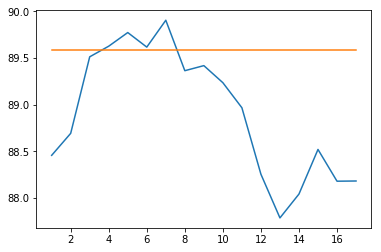

In [24]:
plt.plot(range(1,18), W.Ts)
plt.plot(range(1,18), [89.59]*17)

In [9]:
W2 = worker.T_optim(speedDF)

worker v0.2
Z3 Created!
n = 65
Z Centré !


In [10]:
%%time
W2.run()


--------------------
------ STEP 1 ------
--------------------

Splitting data
Train: X1 shape: (45, 556) X2 shape: (810, 556)
Test: X1 shape: (20, 556) X2 shape: (360, 556)

Training on 20 processors...
Training done in  388.6070713996887 seconds
MSE: 100.32089699966409

--------------------
------ STEP 2 ------
--------------------

Splitting data
Train: X1 shape: (90, 556) X2 shape: (765, 556)
Test: X1 shape: (40, 556) X2 shape: (340, 556)

Training on 20 processors...
Training done in  428.9380078315735 seconds
MSE: 100.82066943669241

--------------------
------ STEP 3 ------
--------------------

Splitting data
Train: X1 shape: (135, 556) X2 shape: (720, 556)
Test: X1 shape: (60, 556) X2 shape: (320, 556)

Training on 20 processors...
Training done in  471.4565269947052 seconds
MSE: 101.05199147381843

--------------------
------ STEP 4 ------
--------------------

Splitting data
Train: X1 shape: (180, 556) X2 shape: (675, 556)
Test: X1 shape: (80, 556) X2 shape: (300, 556)

Tra

/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Training done in  641.0438439846039 seconds
MSE: 101.25406812604716

--------------------
------ STEP 5 ------
--------------------

Splitting data
Train: X1 shape: (225, 556) X2 shape: (630, 556)
Test: X1 shape: (100, 556) X2 shape: (280, 556)

Training on 20 processors...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Training done in  579.2586665153503 seconds
MSE: 101.23306444428914

--------------------
------ STEP 6 ------
--------------------

Splitting data
Train: X1 shape: (270, 556) X2 shape: (585, 556)
Test: X1 shape: (120, 556) X2 shape: (260, 556)

Training on 20 processors...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Training done in  455.8152551651001 seconds
MSE: 101.15883647782329

--------------------
------ STEP 7 ------
--------------------

Splitting data
Train: X1 shape: (315, 556) X2 shape: (540, 556)
Test: X1 shape: (140, 556) X2 shape: (240, 556)

Training on 20 processors...
Training done in  372.35116267204285 seconds
MSE: 101.20461658848455

--------------------
------ STEP 8 ------
--------------------

Splitting data
Train: X1 shape: (360, 556) X2 shape: (495, 556)
Test: X1 shape: (160, 556) X2 shape: (220, 556)

Training on 20 processors...
Training done in  290.0502245426178 seconds
MSE: 101.09104760194461

--------------------
------ STEP 9 ------
--------------------

Splitting data
Train: X1 shape: (405, 556) X2 shape: (450, 556)
Test: X1 shape: (180, 556) X2 shape: (200, 556)

Training on 20 processors...
Training done in  244.89900159835815 seconds
MSE: 100.90205675387031

--------------------
------ STEP 10 ------
--------------------

Splitting data
Train: X1 shape: (450, 5

/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training done in  444.068710565567 seconds
MSE: 100.73184378317795

--------------------
------ STEP 15 ------
--------------------

Splitting data
Train: X1 shape: (675, 556) X2 shape: (180, 556)
Test: X1 shape: (300, 556) X2 shape: (80, 556)

Training on 20 processors...


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training done in  532.4327018260956 seconds
MSE: 100.9070990670666

--------------------
------ STEP 16 ------
--------------------

Splitting data
Train: X1 shape: (720, 556) X2 shape: (135, 556)
Test: X1 shape: (320, 556) X2 shape: (60, 556)

Training on 20 processors...
Training done in  414.14392828941345 seconds
MSE: 100.79962888595428

--------------------
------ STEP 17 ------
--------------------

Splitting data
Train: X1 shape: (765, 556) X2 shape: (90, 556)
Test: X1 shape: (340, 556) X2 shape: (40, 556)

Training on 20 processors...
Training done in  399.4573087692261 seconds
MSE: 100.59669428862325
CPU times: user 1min 25s, sys: 3min 52s, total: 5min 17s
Wall time: 1h 51min 45s


In [11]:
W2.Ts

[100.32089699966409,
 100.82066943669241,
 101.05199147381843,
 101.25406812604716,
 101.23306444428914,
 101.15883647782329,
 101.20461658848455,
 101.09104760194461,
 100.90205675387031,
 100.81888286342877,
 100.80448068158483,
 100.93378478738838,
 100.74984946419683,
 100.73184378317795,
 100.9070990670666,
 100.79962888595428,
 100.59669428862325]

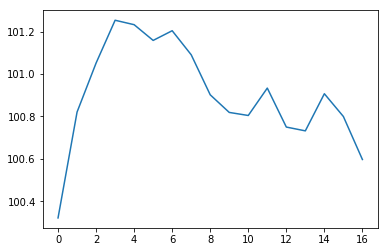

In [12]:


plt.plot(W2.Ts)
plt.plot(range(1,18), [99.58]*17)
